In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1xFLxi8Akn1iRQ6jFW2A4-jBBHZxup21b',
dest_path='content/food_classifier_data.zip',
unzip=True)

Unzipping...Done.


In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
import warnings
warnings.filterwarnings('ignore')


In [ ]:
train=pd.read_csv('/content/content/food_classifier_data/Training_set_food.csv')
test=pd.read_csv('/content/content/food_classifier_data/Testing_set_food.csv')
train.head(6)

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers
5,Image_6.jpg,burgers


In [ ]:
test.head(5)

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
path= '/content/content/food_classifier_data/'
k= '/content/content/food_classifier_data/Training_set_food.csv'
p ='/content/content/food_classifier_data/Testing_set_food.csv'

In [ ]:
path= '/content/content/food_classifier_data/train/'
tfms = get_transforms(flip_vert=True,max_zoom=1.5,max_warp=0,do_flip=True,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../Training_set_food.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0,bs=8))

In [ ]:
val=data.classes
print(val)

['Pizza', 'Softdrinks', 'burgers']


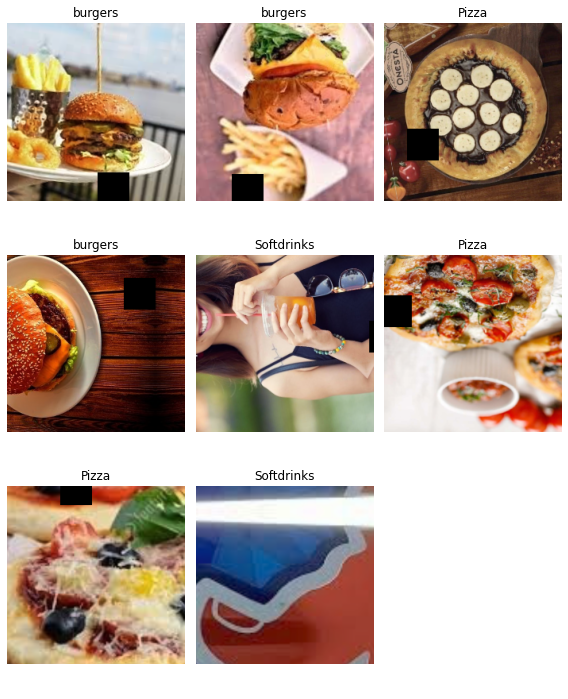

In [ ]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

In [ ]:
## print the target classes
print(data.classes)

['Pizza', 'Softdrinks', 'burgers']


In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/tmp/data011"

In [ ]:

def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [ ]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
#Path(ROOT).mkdir(exist_ok=True, parents=True)
src1 = "/content/content/food_classifier_data"
shutil.copytree(src1, ROOT)


if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(1):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.vgg19_bn, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(2, max_lr=1e-4, callbacks=[cb])
        #learn.fit_one_cycle(5, max_lr=5e-5, callbacks=[cb])
        learn.fit_one_cycle(3, max_lr=1e-5, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(3, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)

(5400, 2) (1800, 1)
Starting fold 0
(5062,) (338,)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.348781,0.103479,0.973373,01:34
1,0.225641,0.069957,0.976331,01:31
2,0.174614,0.060352,0.985207,01:30
3,0.114172,0.045764,0.985207,01:30


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.142476,0.113347,0.967456,01:41
1,0.077031,0.039505,0.985207,01:39


Save the best acc 0.96746
Save the best acc 0.98521


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.054191,0.035884,0.985207,01:40
1,0.059227,0.042426,0.985207,01:38
2,0.047297,0.040322,0.985207,01:40


Save the best acc 0.98521


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.036503,0.037576,0.985207,01:39
1,0.044446,0.037955,0.985207,01:40


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.051196,0.040998,0.985207,01:38
1,0.056918,0.037378,0.985207,01:39
2,0.041025,0.034791,0.982249,01:39


Save the best acc 0.98225


F1 score for this fold  0.9881516545097454


In [ ]:
x = np.argmax(test_preds_all, axis=1)
x

array([1, 1, 1, 2, ..., 0, 0, 1, 1])

In [ ]:
xx=['Pizza', 'Softdrinks', 'burgers']
y=[]
for i in x:
  y.append(xx[i])

In [ ]:
submission = pd.DataFrame({
        "prediction":y
    })
submission.to_csv('./DP_Food.csv', index=False)
print(submission)

      prediction
0     Softdrinks
1     Softdrinks
2     Softdrinks
3        burgers
4     Softdrinks
...          ...
1795       Pizza
1796       Pizza
1797       Pizza
1798  Softdrinks
1799  Softdrinks

[1800 rows x 1 columns]


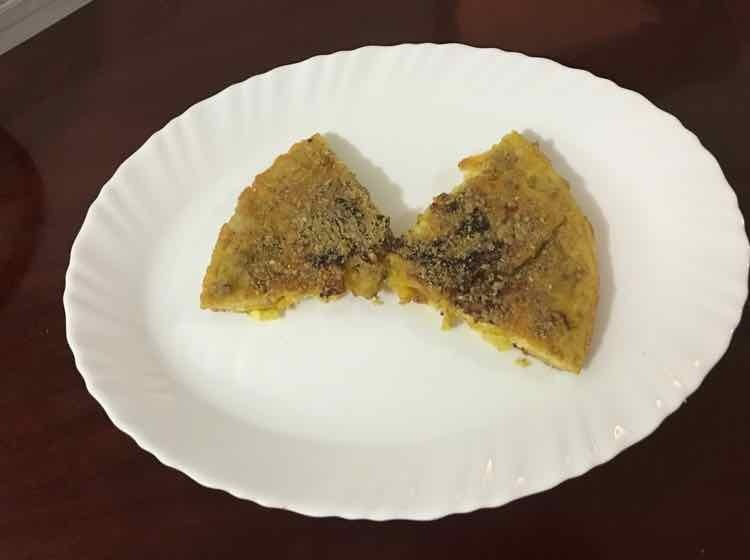

In [ ]:
from PIL import Image
im = Image.open("/content/content/food_classifier_data/test/Image_674.jpg")
im

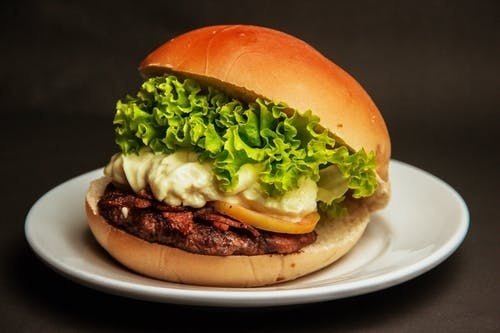

In [ ]:
from PIL import Image
im = Image.open("/content/content/food_classifier_data/test/Image_786.jpg")
im

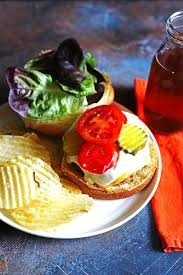

In [ ]:
from PIL import Image
im = Image.open("/content/content/food_classifier_data/test/Image_1179.jpg")
im

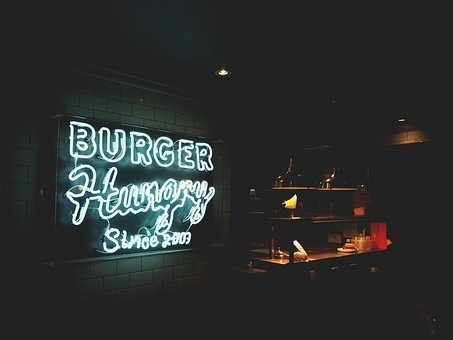

In [ ]:
from PIL import Image
im = Image.open("/content/content/food_classifier_data/test/Image_732.jpg")
im

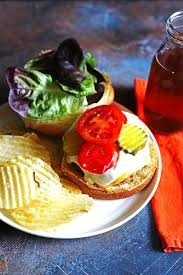

In [ ]:
from PIL import Image
im = Image.open("/content/content/food_classifier_data/test/Image_1179.jpg")
im

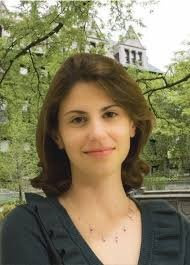

In [ ]:
from PIL import Image
im = Image.open("/content/content/food_classifier_data/test/Image_1508.jpg")
im